# Flow-Temp Model Test

## Import dependencies and data

In [33]:
# import dependencies
import os
import json
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

from sklearn.linear_model import Ridge, LinearRegression, Lasso

In [2]:
# define relevant paths
home_path = os.path.dirname(os.getcwd())
data_path = home_path + '\\data\\'
plot_path = home_path + '\\plotting\\plots\\'

In [50]:
# get merged data
data = pd.read_csv(
    data_path + 'data_merged.csv',
    header=[0, 1],
    index_col=[0, 1, 2, 3]
)

# convert index.date col to datetime
data.index = data.index.set_levels(
    levels=pd.to_datetime(data.index.get_level_values(3).values),
    level=3
)

In [51]:
# define X vars
x_vars = [
    ('flow', 'TA01_GP101_default'),
    ('temperatures', 'TA01_GT10X_GM10X'),
    ('temperatures', 'DC_GT301_damped'),
    ('temperatures', 'DC_GT401_GM401'),
    #('setpoints', 'TA01_GT10X_GM10X_default')
]

# filter columns to keep only x_vars
data = data[x_vars].copy()

## Describe Df

In [5]:
# print number of NAs
print('Number of NAs\n')
print(data.isna().sum())
print('\n\n')

Number of NAs

category      sensor_ID         
flow          TA01_GP101_default    0
temperatures  TA01_GT10X_GM10X      0
              DC_GT301_damped       0
              DC_GT401_GM401        0
dtype: int64





In [6]:
# describe cols
data.describe().transpose()

count         mean         std   min  \
category     sensor_ID                                                     
flow         TA01_GP101_default  166921.0  2354.738858  631.850358   0.0   
temperatures TA01_GT10X_GM10X    166921.0    20.287643    1.043412   0.0   
             DC_GT301_damped     166921.0    -5.166278    6.829758 -21.6   
             DC_GT401_GM401      166921.0    49.677559    3.609970   0.0   

                                    25%     50%     75%     max  
category     sensor_ID                                           
flow         TA01_GP101_default  1864.0  2114.8  2718.4  4206.6  
temperatures TA01_GT10X_GM10X      19.9    20.1    20.5    29.2  
             DC_GT301_damped      -10.8    -3.8     0.5     8.4  
             DC_GT401_GM401        49.0    50.4    51.6    55.9

## Process / transform variables 

In [7]:
# STEPS
fsteps = 20
bsteps = 40

# create forward temp variable
data[('temperatures', 'TA01_GT10X_GM10X_forward')] = data.temperatures.TA01_GT10X_GM10X.shift(periods=-fsteps)

# create first differences f. FORWARD GH temp
data[('temperatures', 'TA01_GT10X_GM10X_fdiff')] = data.temperatures.TA01_GT10X_GM10X_forward.diff(periods=bsteps)

# create first differences f. DC temp
data[('temperatures', 'DC_GT401_GM401_diff')] = data.temperatures.DC_GT401_GM401.diff(periods=bsteps)

# create first differences f. OUT temp
data[('temperatures', 'DC_GT301_damped_diff')] = data.temperatures.DC_GT301_damped.diff(periods=40)

# create first differences f. DC flow
#data[('flow', 'TA01_GP101_default_fdiff1')] = data.flow.TA01_GP101_default.diff(periods=steps * 1.5)
data[('flow', 'TA01_GP101_default_diff')] = data.flow.TA01_GP101_default.diff(periods=bsteps)
#data[('flow', 'TA01_GP101_default_fdiff3')] = data.flow.TA01_GP101_default.diff(periods=steps // 2)

# get mixed effects
def col_transf(col):
    
    # transform all nums to at least one.
    col = col.apply(lambda vals: max(vals, 1))
    
    return col

data[('mixed', 'flow_temp')] = col_transf(data[('temperatures', 'DC_GT401_GM401')]) \
                                * col_transf(data[('flow', 'TA01_GP101_default')])

data[('mixed', 'flow_temp_diff')] = data.mixed.flow_temp.diff(periods=bsteps)

# crop dataset
data = data.iloc[bsteps:-fsteps].copy()

### Plot pairwise correlation matrix

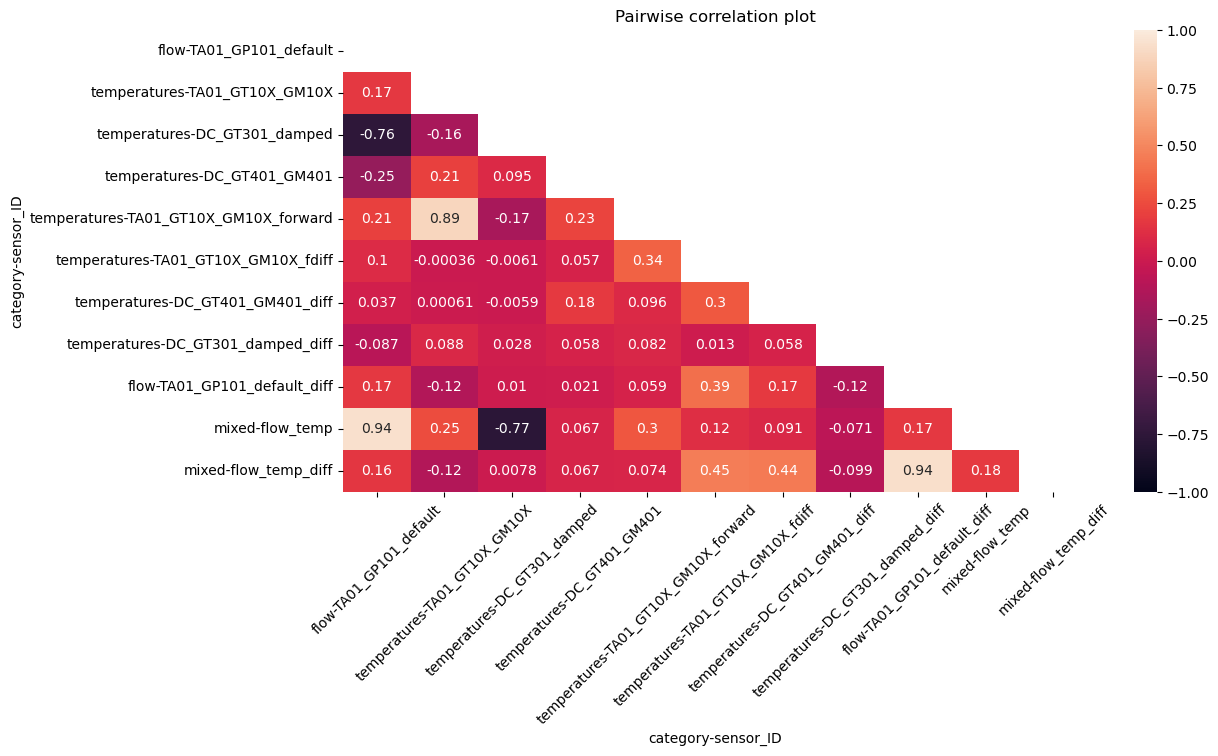

In [8]:
corr = data.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(12, 6))
sns.heatmap(corr, mask=mask, vmin=-1.0, vmax=1.0, annot=True)

plt.xticks(rotation=45)
plt.title('Pairwise correlation plot')
plt.show()

# delete correlation data
del corr

## Preparing data

### Data selection and whitening

In [9]:
# Define model variables
model_vars = [
    ('temperatures', 'TA01_GT10X_GM10X_fdiff'),
    ('temperatures', 'DC_GT401_GM401_diff'),
    ('temperatures', 'DC_GT301_damped_diff'),
    ('flow', 'TA01_GP101_default_diff'),
#     ('mixed', 'temp_flow'),
    ('mixed', 'flow_temp_diff'),
#     ('mixed', 'temp_flow_diff2'),
#     ('mixed', 'temp_flow_diff3'),
#    ('mixed', 'temp_flow2),
]

# filter data
data = data[model_vars].copy()

In [53]:
# normalize all columns
for col in data.columns:
    data[col] = (data[col] - data[col].mean()) / data[col].std()

### Create sequences

In [11]:
# N step range
n_steps = bsteps + fsteps

# get flagged dates
data['day'] = data.index.get_level_values(1).values
data['date_flag'] = data.day - data.day.shift(periods=n_steps) > 1

# remove erroneous rows
data = data[data.date_flag == 0]

# delete cols
del data['day'], data['date_flag']

In [12]:
# get X, Y
Y = data.pop(('temperatures', 'TA01_GT10X_GM10X_fdiff')).values
X = data.values

# save X, targets for testing
X, examp_X  = X[:-8640], X[-8640:]
Y, examp_Y  = Y[:-8640], Y[-8640:]

# delete data
#del data

### Shuffle and split dataset

In [13]:
# get random indices
idxs = np.arange(len(X))
np.random.shuffle(idxs)

# shuffle sequences and targets
X = np.squeeze(X[idxs])
Y = np.squeeze(Y[idxs])

In [14]:
# split data
train_n = int(len(X) * 0.8)
#test_n = len(targets) - train_n

X_train, X_test = X[:train_n], X[train_n:]
Y_train, Y_test = Y[:train_n], Y[train_n:]

In [15]:
# delete vars
del X, Y

## Deploy RIDGE model

In [30]:
model = Ridge(
#     alpha=1.0,
#     fit_intercept=False
)

C = model.fit(X_train, Y_train)
C.coef_

array([ 0.11196345,  0.03901784, -0.00269697,  0.42093663])

In [47]:
Y_preds = model.predict(X_test)
np.corrcoef(np.squeeze(Y_preds), Y_test)

987/987 [==============================] - 3s 3ms/step


array([[1.        , 0.48703462],
       [0.48703462, 1.        ]])

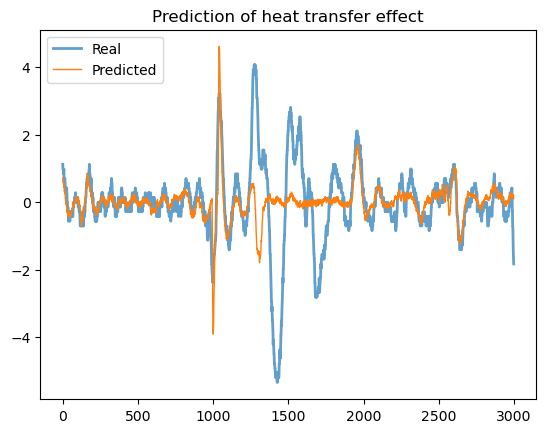

In [31]:
examp_preds = model.predict(examp_X)

plt.plot(examp_Y[-3000:-1], linewidth=2.0, alpha=0.7, label='Real')
plt.plot(examp_preds[-3000:-1], linewidth=1.0, alpha=1.0, label='Predicted')

plt.title('Prediction of heat transfer effect')
plt.legend(loc='upper left')
plt.show()

## Deploy ANN

In [41]:
layerList = [
    layers.Input(shape=(
        X_train.shape[1],
    )),
    layers.Dense(
        units=128,
        activation="relu",
        activity_regularizer='l2'
    ),
    layers.Dropout(rate=0.4),
    layers.Dense(
        units=128,
        activation="relu",
        activity_regularizer='l2'
    ),
    layers.Dropout(rate=0.4),
    layers.Dense(
        units=64,
        activation="relu",
        activity_regularizer='l2'
    ),
    layers.Dropout(rate=0.4),
    layers.Dense(1, activation=None)
]

In [42]:
model = tf.keras.models.Sequential(layers=layerList, name='model')
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 128)               640       
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 128)               16512     
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                 65    

In [43]:
trainHist = model.fit(
    X_train,
    Y_train,
    epochs=20,
    batch_size=128,
    validation_split=0.2,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

Epoch 1/20
790/790 [==============================] - 10s 10ms/step - loss: 0.8620 - val_loss: 0.9296
Epoch 2/20
790/790 [==============================] - 8s 9ms/step - loss: 0.8198 - val_loss: 0.9099
Epoch 3/20
790/790 [==============================] - 8s 10ms/step - loss: 0.8062 - val_loss: 0.8935
Epoch 4/20
790/790 [==============================] - 8s 10ms/step - loss: 0.8149 - val_loss: 0.8956
Epoch 5/20
790/790 [==============================] - 8s 10ms/step - loss: 0.8021 - val_loss: 0.9039
Epoch 6/20
790/790 [==============================] - 8s 10ms/step - loss: 0.8026 - val_loss: 0.8988
Epoch 7/20
790/790 [==============================] - 8s 10ms/step - loss: 0.8076 - val_loss: 0.8912
Epoch 8/20
790/790 [==============================] - 8s 10ms/step - loss: 0.7963 - val_loss: 0.8851
Epoch 9/20
790/790 [==============================] - 8s 10ms/step - loss: 0.8022 - val_loss: 0.8851
Epoch 10/20
790/790 [==============================] - 8s 10ms/step - loss: 0.7982 - val_lo

270/270 [==============================] - 1s 3ms/step


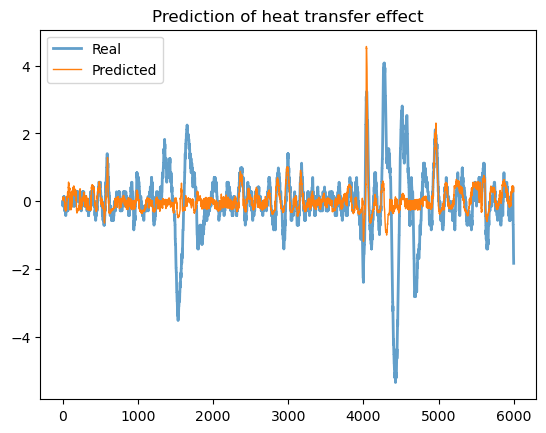

In [49]:
examp_preds = model.predict(examp_X)

plt.plot(examp_Y[-6000:-1], linewidth=2.0, alpha=0.7, label='Real')
plt.plot(examp_preds[-6000:-1], linewidth=1.0, alpha=1.0, label='Predicted')

plt.title('Prediction of heat transfer effect')
plt.legend(loc='upper left')
plt.show()

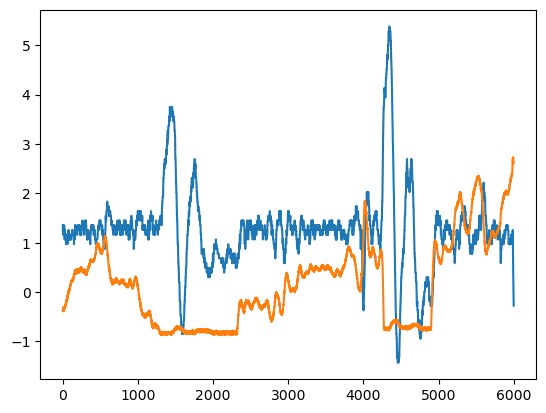

In [66]:
plt.plot(data.temperatures.TA01_GT10X_GM10X.values[-6000:])
#plt.plot(data.temperatures.DC_GT401_GM401.values[-6000:])
plt.plot(data.flow.TA01_GP101_default.values[-6000:])